[How to Develop a Deep Learning Photo Caption Generator from Scratch](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/)

Change paths according to your file organization throughout the notebook

## Downloading Dataset

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip .

In [ ]:
!unzip Flickr8k_Dataset.zip

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip .

In [ ]:
!unzip Flickr8k_text.zip

In [ ]:
!mkdir data && mv Flicker8k_Dataset data

In [ ]:
!mv /content/Flickr_8k.trainImages.txt /content/gdrive/My\ Drive/Colab\ Notebooks/PyTorch/ImageCaptioning

In [ ]:
!mv /content/Flickr_8k.devImages.txt /content/gdrive/My\ Drive/Colab\ Notebooks/PyTorch/ImageCaptioning

In [ ]:
!mv /content/Flickr_8k.testImages.txt /content/gdrive/My\ Drive/Colab\ Notebooks/PyTorch/ImageCaptioning

## Import Libs

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models

import os

import numpy as np

from IPython import display
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

import string

from pickle import dump, load

In [ ]:
# You're lucky if you get a Tesla P100 rather than an older K80
!nvidia-smi

In [ ]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Feature Extractor

We will remove the last layer from the loaded VGG-16 model, as this is the model used to predict a classification for a photo. We are not interested in classifying images, but we are interested in the internal representation of the photo right before a classification is made. These are the “features” that the model has extracted from the photo. The image features are a 1-dimensional 4,096 element vector.

In [ ]:
# Load pretrained VGG16
vgg16 = models.vgg16(pretrained=True)

# Add a flatten layer before the classifier block and remove the last fully connected layer
blocks = list(vgg16.children())
blocks = list([blocks[0], blocks[1], nn.Flatten(), blocks[2][:-1]])
vgg16 = nn.Sequential(*blocks)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
# Check the output shape
vgg16(torch.rand((1, 3, 224, 224))).shape

torch.Size([1, 4096])

In [ ]:
def preprocess_image(image_name):
  transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(), # automatic normalization of a PIL.Image to [0,1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization according to official documentation
  ])
  image = Image.open(image_name)
  image = transform(image).float()
  image = image.unsqueeze(0) # models require [batch, channel, heigth, width]
  return image

def extract_features(directory):
  # extract features from each photo
  features = dict()
  vgg16.eval()
  with torch.no_grad():
    for i, name in enumerate(os.listdir(directory)):
      # load an image from file
      filename = directory + '/' + name
      image = preprocess_image(filename)
      # get features
      feature = vgg16(image)
      # get image id
      image_id = name.split('.')[0]
      # store feature
      features[image_id] = feature
      print('>{}, {}'.format(i, name))
    return features

In [ ]:
# Extract features from all images
features = extract_features('/content/data/Flicker8k_Dataset')
print('Extracted Features: %d' % len(features))
# Save to file
dump(features, open('/content/features.pkl', 'wb'))

In [ ]:
!mv /content/features.pkl /content/gdrive/My\ Drive/Colab\ Notebooks/PyTorch/ImageCaptioning

## Prepare Text Data

In [ ]:
# Load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
filename = '/content/Flickr8k.token.txt'
# Load descriptions
doc = load_doc(filename)

Each photo has a unique identifier. This identifier is used on the photo filename and in the text file of descriptions.

Next, we will step through the list of photo descriptions. Below defines a function _load_descriptions()_ that, given the loaded document text, will return a dictionary of photo identifiers to descriptions. Each photo identifier maps to a list of one or more textual descriptions.

In [ ]:
# Extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# Parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


We will clean the text in the following ways in order to reduce the size of the vocabulary of words we will need to work with:

<ul>
<li>Convert all words to lowercase.</li>
<li>Remove all punctuation.</li>
<li>Remove all words that are one character or less in length (e.g. ‘a’).</li>
<li>Remove all words with numbers in them.</li>
</ul>

In [ ]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# Clean descriptions
clean_descriptions(descriptions)

Once cleaned, we can summarize the size of the vocabulary. For reference, we can transform the clean descriptions into a set and print its size to get an idea of the size of our dataset vocabulary.

In [ ]:
# Convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# Summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8763


Finally, we can save the dictionary of image identifiers and descriptions to a new file named descriptions.txt, with one image identifier and description per line. Below defines the _save_descriptions()_ function that, given a dictionary containing the mapping of identifiers to descriptions and a filename, saves the mapping to file.

In [ ]:
# Save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, '/content/descriptions.txt')

In [ ]:
mv /content/descriptions.txt /content/gdrive/My\ Drive/Colab\ Notebooks/PyTorch/ImageCaptioning

## Develop Deep Learning Model

### Loading Data

The train and development dataset have been predefined in the _Flickr_8k.trainImages.txt_ and _Flickr_8k.devImages.txt_ files respectively, that both contain lists of photo file names. From these file names, we can extract the photo identifiers and use these identifiers to filter photos and descriptions for each set.

The function _load_set()_ below will load a pre-defined set of identifiers given the train or development sets filename.

In [ ]:
# Load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# Load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

Below is the function _load_clean_descriptions()_ that loads the cleaned text descriptions from _descriptions.txt_ for a given set (train or validation) of identifiers and returns a dictionary of identifiers to lists of text descriptions.

The model we will develop will generate a caption given a photo, and the caption will be generated one word at a time. The sequence of previously generated words will be provided as input. Therefore, we will need a first word to kick-off the generation process and a last word to signal the end of the caption.

We will use the strings _startseq_ and _endseq_ for this purpose. These tokens are added to the loaded descriptions as they are loaded. It is important to do this now before we encode the text so that the tokens are also encoded correctly.

In [ ]:
# Load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

Next, we can load the photo features for a given dataset.

Below defines a function named _load_photo_features()_ that loads the entire set of photo descriptions, then returns the subset of interest for a given set of photo identifiers.

In [ ]:
# Load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

In [ ]:
# load training dataset (6K)
train = load_set('/content/gdrive/My Drive/Colab Notebooks/PyTorch/ImageCaptioning/Flickr_8k.trainImages.txt')
print('Train Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('/content/gdrive/My Drive/Colab Notebooks/PyTorch/ImageCaptioning/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('/content/gdrive/My Drive/Colab Notebooks/PyTorch/ImageCaptioning/features.pkl', train)
print('Photos: train=%d' % len(train_features))

Train Dataset: 6000
Descriptions: train=6000
Photos: train=6000


The description text will need to be encoded to numbers before it can be presented to the model as in input or compared to the model’s predictions.

The first step in encoding the data is to create a consistent mapping from words to unique integer values. Keras provides the _Tokenizer_ class that can learn this mapping from the loaded description data.

Below defines the _to_lines()_ to convert the dictionary of descriptions into a list of strings and the create_tokenizer() function that will fit a Tokenizer given the loaded photo description text.

In [ ]:
!pip install --upgrade tensorflow==2.0.0

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# Fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# Prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


We can now encode the text.

Each description will be split into words. The model will be provided one word and the photo and generate the next word. Then the first two words of the description will be provided to the model as input with the image to generate the next word. This is how the model will be trained.

For example, the input sequence “little girl running in field” would be split into 6 input-output pairs to train the model:

```text
X1,	  X2 (text sequence), 						   y (word)

photo	startseq, 							         little

photo	startseq, little,							  girl

photo	startseq, little, girl, 					   running

photo	startseq, little, girl, running, 			  in

photo	startseq, little, girl, running, in, 		  field

photo	startseq, little, girl, running, in, field,    endseq
```

Later, when the model is used to generate descriptions, the generated words will be concatenated and recursively provided as input to generate a caption for an image.

The function below named _create_sequences()_, given the tokenizer, a maximum sequence length, and the dictionary of all descriptions and photos, will transform the data into input-output pairs of data for training the model. There are two input arrays to the model: one for photo features and one for the encoded text. There is one output for the model which is the encoded next word in the text sequence.

The input text is encoded as integers, which will be fed to a word embedding layer. The photo features will be fed directly to another part of the model. The model will output a prediction, which will be a probability distribution over all words in the vocabulary.

The output data will therefore be a one-hot encoded version of each word, representing an idealized probability distribution with 0 values at all word positions except the actual word position, which has a value of 1.

In [ ]:
# Calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# Create sequences of input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in list(descriptions.items()):
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# store
				X1.append(key)
				X2.append(in_seq)
				y.append(out_seq)
	return X1, torch.FloatTensor(X2), torch.FloatTensor(y)

Description Length: 34


We now have enough to load the data for the training and development datasets and transform the loaded data into input-output pairs for fitting a deep learning model.

In [ ]:
# Train dataset

# prepare sequences
X1_train, X2_train, y_train = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

In [ ]:
# Validation dataset

# load validation set
val = load_set('/content/gdrive/My Drive/Colab Notebooks/PyTorch/ImageCaptioning/Flickr_8k.devImages.txt')
print('Validation Dataset: %d' % len(val))
# descriptions
val_descriptions = load_clean_descriptions('/content/gdrive/My Drive/Colab Notebooks/PyTorch/ImageCaptioning/descriptions.txt', val)
print('Descriptions: val=%d' % len(val_descriptions))
# photo features
val_features = load_photo_features('/content/gdrive/My Drive/Colab Notebooks/PyTorch/ImageCaptioning/features.pkl', val)
print('Photos: test=%d' % len(val_features))
# prepare sequences
X1_val, X2_val, y_val = create_sequences(tokenizer, max_length, val_descriptions, val_features, vocab_size)

Validation Dataset: 1000
Descriptions: val=1000
Photos: test=1000


### Defining Model

![https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/09/Schematic-of-the-Merge-Model-For-Image-Captioning.png](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/09/Schematic-of-the-Merge-Model-For-Image-Captioning.png)

We will describe the model in three parts:

<ul>
<li>Photo Feature Extractor: This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input.</li>
<li>Sequence Processor: This is a word embedding layer for handling the text input, followed by a Long Short-Term Memory (LSTM) recurrent neural network layer.</li>
<li>Decoder: Both the feature extractor and sequence processor output a fixed-length vector. These are merged together and processed by a Dense layer to make a final prediction.</li>
</ul>

The Photo Feature Extractor model expects input photo features to be a vector of 4,096 elements. These are processed by a fully connected layer to produce a 256 element representation of the photo.

The Sequence Processor model expects input sequences with a pre-defined length (34 words) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an LSTM layer with 256 memory units.

Both the input models produce a 256 element vector. Further, both input models use regularization in the form of 50% dropout. This is to reduce overfitting the training dataset, as this model configuration learns very fast.

The Decoder model merges the vectors from both input models using an addition operation. This is then fed to a fully connected 256 neuron layer and then to a final output fully connected layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

In [ ]:
n_epochs = 10
batch_size = 32 # for training
vocab_size = 7579

In [ ]:
# Feature Extractor Model

class PhotoFeatureExtractor(nn.Module):
  def __init__(self):
    super(PhotoFeatureExtractor, self).__init__()
    self.dropout = nn.Dropout(p=0.5, inplace=True)
    self.fc = nn.Sequential(
        nn.Linear(4096, 256),
        nn.ReLU(inplace=True)
    )
  def forward(self, x):
    return self.fc(self.dropout(x))

#pfe = PhotoFeatureExtractor().to(device)
#print(pfe)

In [ ]:
# Test the photo feature extractor on a random batch
'''
x = torch.randn(batch_size, 4096)
out = pfe(x)
print(out.shape)
'''

In [ ]:
# Sequence Processor Model

class SequenceProcessor(nn.Module):

  def __init__(self, vocab_size):
    super(SequenceProcessor, self).__init__()
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(self.vocab_size, 256, padding_idx=0)
    self.dropout = nn.Dropout(p=0.5, inplace=True)
    self.lstm = nn.LSTM(256, 256, 1, batch_first=True)

  def forward(self, x, hidden):
    lstm_out, hidden = self.lstm(self.dropout(self.embedding(x.long())), hidden)
    return lstm_out, hidden

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = (weight.new(1, batch_size, 256).zero_().to(device),
              weight.new(1, batch_size, 256).zero_().to(device))
    return hidden

#sp = SequenceProcessor(vocab_size).to(device)
#print(sp)

In [ ]:
# Test the sequence processor on a batch
'''
x = X2_train[:batch_size].long().to(device)
h = sp.init_hidden(batch_size)
out, hidden = sp(x, h)
print(out.shape)
print(hidden[0].shape, hidden[1].shape)
print(out[:,-1,:].shape)
'''

In [ ]:
# Decoder Model

class Decoder(nn.Module):

  def __init__(self, vocab_size):
    super(Decoder, self).__init__()
    self.vocab_size = vocab_size
    self.pfe = PhotoFeatureExtractor()
    self.sp = SequenceProcessor(self.vocab_size)
    self.fc1 = nn.Sequential(
      nn.Linear(256, 256),
      nn.ReLU(inplace=True)
    )
    self.fc2 = nn.Linear(256, self.vocab_size)


  def forward(self, ph, desc):
    h = self.sp.init_hidden(batch_size)
    lstm_out, _ = self.sp(desc, h)
    lstm_out = lstm_out[:,-1,:]
    out = torch.add(self.pfe(ph), lstm_out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

model = Decoder(vocab_size).to(device)
print(model)

Decoder(
  (pfe): PhotoFeatureExtractor(
    (dropout): Dropout(p=0.5, inplace=True)
    (fc): Sequential(
      (0): Linear(in_features=4096, out_features=256, bias=True)
      (1): ReLU(inplace=True)
    )
  )
  (sp): SequenceProcessor(
    (embedding): Embedding(7579, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=True)
    (lstm): LSTM(256, 256, batch_first=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU(inplace=True)
  )
  (fc2): Linear(in_features=256, out_features=7579, bias=True)
)


In [ ]:
# Test the sequence processor on a random batch
ph = torch.randn(batch_size, 4096).to(device)
desc = X2_train[:batch_size].long().to(device)
out = model(ph, desc)
print(out.shape)

torch.Size([32, 7579])


### Create Pytorch Dataset and Dataloader

#### Train set

In [ ]:
# Train set
class TrainDataset(Dataset):
  def __init__(self, X1_train, X2_train, y_train):
    super(TrainDataset, self).__init__()
    self.X1_train = X1_train
    self.X2_train = X2_train
    self.y_train = y_train

  def __len__(self):
    return len(self.X1_train)

  def __getitem__(self, idx):
    return self.X1_train[idx], self.X2_train[idx], self.y_train[idx]

train_ds = TrainDataset(X1_train, X2_train, y_train)


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

In [ ]:
# Test data loader shapes
for ph, desc, out in train_loader:
    print(torch.cat([torch.reshape(train_features[elem][0], (1,-1)) for elem in ph], 0).shape) # merge all features into one tensor of shape (batch_size, 4096)
    print(desc.shape)
    print(out.shape)
    break

torch.Size([32, 4096])
torch.Size([32, 34])
torch.Size([32])


In [ ]:
# Test the model with data loader
for ph, desc, out in train_loader:
    ph = torch.cat([torch.reshape(train_features[elem][0], (1,-1)) for elem in ph], 0)
    print(model(ph, desc).shape)
    break

torch.Size([32, 7579])


#### Validation set

In [ ]:
# Validation set
class ValidationDataset(Dataset):
  def __init__(self, X1_val, X2_val, y_val):
    super(ValidationDataset, self).__init__()
    self.X1_val = X1_val
    self.X2_val = X2_val
    self.y_val = y_val

  def __len__(self):
    return len(self.X1_val)

  def __getitem__(self, idx):
    return self.X1_val[idx], self.X2_val[idx], self.y_val[idx]

val_ds = ValidationDataset(X1_val, X2_val, y_val)


# Data loader
val_loader = torch.utils.data.DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

In [ ]:
# Test data loader shapes
for ph, desc, out in val_loader:
    print(torch.cat([torch.reshape(val_features[elem][0], (1,-1)) for elem in ph], 0).shape) # merge all features into one tensor of shape (batch_size, 4096)
    print(desc.shape)
    print(out.shape)
    break

torch.Size([32, 4096])
torch.Size([32, 34])
torch.Size([32])


In [ ]:
# Test the model with data loader
for ph, desc, out in val_loader:
    ph = torch.cat([torch.reshape(val_features[elem][0], (1,-1)) for elem in ph], 0)
    print(model(ph, desc).shape)
    break

torch.Size([32, 7579])


### Training Model

In [ ]:
lr = 2e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Training

import time

model.train()

valid_loss_min = np.Inf

total_step = len(train_loader)
for epoch in range(n_epochs):
  start = time.time()
  for i, (ph, desc, out) in enumerate(train_loader):
    ph = torch.cat([torch.reshape(train_features[elem][0], (1,-1)) for elem in ph], 0)
    ph, desc, out = ph.to(device), desc.to(device), out.to(device)
    model.zero_grad()
    pred = model(ph, desc)
    loss = criterion(pred.float(), out.long())
    loss.backward()
    optimizer.step()

    if (i+1) % 500 == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss [{:.4f}]'.format(epoch+1, n_epochs, i+1, total_step, loss.item()))

  print('Testing on validation set at the end of epoch {}'.format(epoch+1))
  model.eval()
  val_losses = []
  for i, (ph, desc, out) in enumerate(val_loader):
    ph = torch.cat([torch.reshape(val_features[elem][0], (1,-1)) for elem in ph], 0)
    ph, desc, out = ph.to(device), desc.to(device), out.to(device)
    pred = model(ph, desc)
    val_loss = criterion(pred.float(), out.long())
    val_losses.append(val_loss.item())
  model.train()
  print('Epoch: [{}/{}]...'.format(epoch+1, n_epochs), 'Val Loss: [{:.4f}]'.format(np.mean(val_losses)))

  print ('Time for epoch {} is {:.2f} sec'.format(epoch + 1, time.time()-start))

  if np.mean(val_losses) <= valid_loss_min:
    # save model
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/PyTorch/ImageCaptioning/model.ckpt')
    print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model...'.format(valid_loss_min, np.mean(val_losses)))
    valid_loss_min = np.mean(val_losses)

print ('Total training time is {:.2f} sec'.format(time.time()-start))

Epoch [1/10], Step [500/9575], Loss [5.3499]
Epoch [1/10], Step [1000/9575], Loss [4.4230]
Epoch [1/10], Step [1500/9575], Loss [6.3397]
Epoch [1/10], Step [2000/9575], Loss [4.6158]
Epoch [1/10], Step [2500/9575], Loss [5.7483]
Epoch [1/10], Step [3000/9575], Loss [5.0213]
Epoch [1/10], Step [3500/9575], Loss [4.2397]
Epoch [1/10], Step [4000/9575], Loss [3.2772]
Epoch [1/10], Step [4500/9575], Loss [4.1024]
Epoch [1/10], Step [5000/9575], Loss [3.7307]
Epoch [1/10], Step [5500/9575], Loss [4.0382]
Epoch [1/10], Step [6000/9575], Loss [3.9398]
Epoch [1/10], Step [6500/9575], Loss [3.6618]
Epoch [1/10], Step [7000/9575], Loss [3.5989]
Epoch [1/10], Step [7500/9575], Loss [4.1451]
Epoch [1/10], Step [8000/9575], Loss [4.3598]
Epoch [1/10], Step [8500/9575], Loss [3.8061]
Epoch [1/10], Step [9000/9575], Loss [4.1549]
Epoch [1/10], Step [9500/9575], Loss [3.2254]
Testing on validation set at the end of epoch 1
Epoch: [1/10]... Val Loss: [3.9754]
Time for epoch 1 is 61.83 sec
Validation lo

In [ ]:
# GPU

# Reload the models from last (best) checkpoint
model.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/PyTorch/ImageCaptioning/model.ckpt'))

In [ ]:
# CPU

# Reload the models from last (best) checkpoint
model.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/PyTorch/ImageCaptioning/model.ckpt', map_location=torch.device('cpu')))

<All keys matched successfully>

The model was saved at the end of the epoch with the lowest loss value on the validation set.

The model learns fast and quickly overfits the training dataset. MachineLearningMastery achieved the best score of 3.612 just at the end of epoch 2.

In [ ]:
model.eval()
val_losses = []
for i, (ph, desc, out) in enumerate(val_loader):
  ph = torch.cat([torch.reshape(val_features[elem][0], (1,-1)) for elem in ph], 0)
  ph, desc, out = ph.to(device), desc.to(device), out.to(device)
  pred = model(ph, desc)
  val_loss = criterion(pred.float(), out.long())
  val_losses.append(val_loss.item())
print('Val Loss: [{:.4f}]'.format(np.mean(val_losses)))

Val Loss: [3.7766]


## Evaluate Model

We will evaluate a model by generating descriptions for all photos in the test dataset and evaluating those predictions with a standard cost function.

First, we need to be able to generate a description for a photo using a trained model.

This involves passing in the start description token _startseq_, generating one word, then calling the model recursively with generated words as input until the end of sequence token is reached _endseq_ or the maximum description length is reached.

The function below _named generate_desc()_ implements this behavior and generates a textual description given a trained model, and a given prepared photo as input. It calls the function _word_for_id()_ in order to map an integer prediction back to a word.

In [ ]:
# Map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# Generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		model.eval()
		yhat = nn.Softmax(dim=1)(model(torch.FloatTensor(photo), torch.FloatTensor(sequence)))
		# convert probability to integer
		yhat = torch.argmax(yhat, dim=1).item()
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

We will generate predictions for all photos in the test dataset and in the train dataset.

The function below named _evaluate_model()_ will evaluate a trained model against a given dataset of photo descriptions and photo features. The actual and predicted descriptions are collected and evaluated collectively using the corpus BLEU score that summarizes how close the generated text is to the expected text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
# Evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU scores are used in text translation for evaluating translated text against one or more reference translations.

Here, we compare each generated description against all of the reference descriptions for the photograph. We then calculate BLEU scores for 1, 2, 3 and 4 cumulative n-grams.

The NLTK Python library implements the BLEU score calculation in the _corpus_bleu()_ function. A higher score close to 1.0 is better, a score closer to zero is worse.

In [ ]:
# Evaluate model
batch_size = 1 # we have to evaluate the model working with one photo at a time
evaluate_model(model, val_descriptions, val_features, tokenizer, max_length)

BLEU-1: 0.559846
BLEU-2: 0.304948
BLEU-3: 0.209712
BLEU-4: 0.101447


## Generate New Captions

Now let's generate a description for a new photograph.

First we must extract the features of the photo by means of the modified VGG-16 model, which was used during data preparation.

We will call the _extract_features()_ function used during data preparation, but adapted to work on a single photo.

In [ ]:
def extract_features(filename):
  vgg16.eval()
  with torch.no_grad():
    image = preprocess_image(filename)
    return vgg16(image)

In [ ]:
#!wget https://live.staticflickr.com/1146/1045709386_aef34eac89_w_d.jpg
#!wget https://live.staticflickr.com/3117/2579419586_f473011177_w_d.jpg
#!wget https://live.staticflickr.com/3252/2890899596_4d4aa09413_w_d.jpg
#!wget https://live.staticflickr.com/3616/3701644734_afc8a34dd0_w_d.jpg
#!wget https://live.staticflickr.com/5171/5491257149_0f8997c715_w_d.jpg
#!wget https://live.staticflickr.com/5254/5582708527_94a330ca4b_w_d.jpg
#!wget https://live.staticflickr.com/6015/5897839434_00eac41a6d_w_d.jpg
!wget https://live.staticflickr.com/8430/7837618434_47cb2e9627_w_d.jpg
#!wget https://live.staticflickr.com/8258/8666275620_b1156a39fd_w_d.jpg
#!wget https://live.staticflickr.com/3921/14726617566_48f7acbb40_w_d.jpg
#!wget https://live.staticflickr.com/8604/16592320210_3e3cac9b70_w_d.jpg
#!wget https://live.staticflickr.com/694/23525925409_51a5018d3f_w_d.jpg
#!wget https://live.staticflickr.com/2907/33057665363_563f800689_w_d.jpg
#!wget https://live.staticflickr.com/4353/36754066270_b92f5c41a5_w_d.jp
#!wget https://live.staticflickr.com/1926/45255426481_1570769439_w_d.jpg
#!wget https://live.staticflickr.com/65535/48700396142_726898feb6_w_d.jpg
#!wget https://live.staticflickr.com/65535/48764780601_4a74b451e6_w_d.jpg
#!wget https://live.staticflickr.com/65535/49637521451_1dbd41414d_w_d.jpg

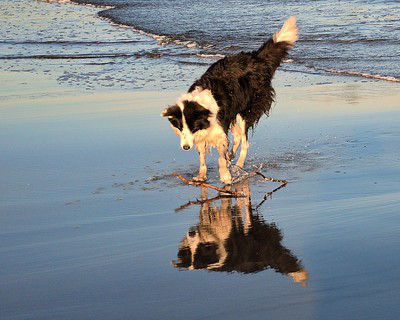

In [ ]:
filename = '/content/7837618434_47cb2e9627_w_d.jpg'
im = Image.open(filename)
im

In [ ]:
photo = extract_features(filename)

# Generate description
batch_size = 1 # we have to evaluate the model working with one photo at a time
description = generate_desc(model, tokenizer, photo, max_length)
print(description[9:-7]) # get rid of 'startseq' and 'endseq' flags

dog is running through the water
